In [1]:
from math import radians, degrees, sin, cos, atan, tan

mpilot  = 90   # kg (including harness and clothing = Hook-in weight)
h       = 1.2  # in m (hang strap length)

mwing   = 22   # kg (mass of wing)
Cmo     = 0.05
I       = 102  # in kg.m**2 according to G.V , I=110;% according to Cook study. Inertia Pilot+ Glider about CGTotal

AR      = 5.5  # Aspect ratio Falcon 5.5
K       = 0.7  # Cmq variable (from Methods for Estimating Stability and Control Derivatives for Standard Subsonic Airplanes (1973) -Roskam p51  )

S       = 15.8 # m^2 Falcon 170 area
c       = 1.9  # m Falcon 170
tpdist  = 8.5*c/100 # en m (distance between CGW et Tether point)
cgdist  = 0.06 # distance between tether point and the CGW
Clwa    = 3.5  # spanwise average value of the wing section lift curve slope (slope of CL between 5 and 15 degrees of alpha)
cbar    = 1.55 # distance between the apex of the downtubes and the control bar axis (optional)
        
Scx     = 0.16 # S.Cx of the pilot position. If prone : Scx=0.16. If stood: Scx=0.66
g       = 9.81 # N/kg or 
rho     = 1.22 # kg/m^3 density of air

M       = mpilot + mwing
phi     = radians(14)   # angle in degrees between the downtube and the axis perpendicular to the keel
sweep   = radians(31)   # Sweep angle at the quarterchord



In [10]:
import scipy.integrate
import numpy

u0    = 0                # initial position along flight path 
v0    = 9                # initial airspeed in m/s
alphr0 = radians(20)     # initial angle of attack (alph=a+f)
ar0    = radians(-10)    # flight path angle in radians Gamma
fr0    = alphr0 + ar0    # pitch attitude in radians/sec Theta
br0    = radians(0)      # Initial pitch rate attitude in radians/sec^2

# z = ([0, u, fr, v, ar, br])
#          u    position, 
#          fr   pitch attitude in radians/sec Theta ]
#          v    airspeed in m/s
#          ar   flight path angle in radians
#          br   pitch rate attitude in radians/sec^2

# all points are relative to the aerodynamic centre
def motions(t, y):
    u, fr, v, ar, br = y[2:]
    
    Lb = 0.4       # 0.4 if forward , -0.74 if backward :distance between the cgpilot and the axis of the control bar,if trim change 'Pil_act'
    Lb = 0.74  if t < 8 else 0.15  # model change in pitch control at t=8seconds
    
    alpha = fr - ar 
    
    Clift  = -16.6*alpha**3 + 11.48*alpha**2 + 1.3*alpha + 0.038
    Cdg    = 7.07*alpha**3 - 4.68*alpha**2 + 1.1*alpha - 0.0144

    vsq    = v**2                  # airspeed square
    lift   = 0.5*rho*vsq*S*Clift
    Dcdg   = 0.5*rho*vsq*Cdg*S     # Drag of the wing alone
    Dpilot = 0.5*rho*vsq*Scx       # Drag of the pilot alone
    drag   = Dcdg + Dpilot         # Drag of the system (wing + pilot)
    
    dyn    = 0.5*rho*vsq*S         # dynamic pressure
    

    TP     = tpdist*numpy.array([cos(fr), sin(fr)])       # Tether point
    CGW    = TP + cgdist*numpy.array([cos(fr), sin(fr)])  # CG of wing
    ksi  = atan(Lb/h)                   # angle between cg pilot and the downtubes
    CGP  = TP + h*numpy.array([sin(fr+phi+ksi), -cos(fr+phi+ksi)])  # CG of pilot
    CGT  = (CGP*mpilot + CGW*mwing)/(mpilot + mwing)  # Position CG of the system (pilot+wing)

    # Tau=z[4];
    Cx  = -Dcdg;
    Cy  = lift;
    d   = numpy.sqrt(sum(CGT**2))  # norm

    Xw  = CGT[0];
    Cmq = -K*Clwa*cos(sweep)*((((1/24)*(AR**3*tan(sweep)**2)/(AR + 6*cos(sweep))) + 1/8) + (AR*(2*(Xw/c) + 0.5*(Xw/c))/(AR+2*cos(sweep))))

    # Damping
    Mq  = (Cmq*br*c**2*rho*v*S)/4
    Mq2 = -0.5*rho*Cdg*S*(-2*br*d**2*v + br**2*d**3) 

    XWT = CGW[0] - CGT[0]
    XP  = CGP[0] - CGT[0]
    YP  = CGP[1] - CGT[1]

    # Differential equations
    dy = numpy.zeros(7)
    dy[0] = v*cos(ar)    # change in x
    dy[1] = v*sin(ar)    # change in altitude
    dy[2] = v
    dy[3] = br
    dy[4] = -g*sin(ar) - (drag/M)
    dy[5] = (1/v*(-g*cos(ar) + (lift/M)))
    dy[6] = (Cmo*dyn*c + mwing*g*XWT + mpilot*g*XP - Cy*CGT[0] - Cx*(-CGT[1]) - YP*Dpilot + Mq + Mq2)/I 
          # drag of the pilot applied on CGP
    
    return dy

t_span = (0, 18)
y0 = numpy.array([0, 0, u0, fr0, v0, ar0, br0])
t_eval=numpy.linspace(t_span[0], t_span[1], 81)
res = scipy.integrate.solve_ivp(motions, t_span, y0, 'RK45', t_eval)


Text(0.5, 1.0, 'glide path')

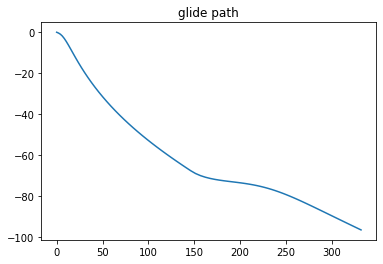

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(res.y[0,:], res.y[1,:])
plt.title("glide path")